In [35]:
import torch
from torch.utils.data import Dataset, DataLoader
# from torchsummary import summary # Problem installing this module

Define the input and output

In [36]:
x = [[1,2],[3,4],[5,6],[7,8]] # input
y = [[3],[7],[11],[15]] # output

Convert to tensor input

In [37]:
X = torch.tensor(x).float()
Y = torch.tensor(y).float()

Check to see if GPU is available

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

X = X.to(device)
Y = Y.to(device)

cpu


Instanciate a dataset class

In [39]:
class MyDataset(Dataset):

    def __init__(self,x,y):
        self.x = torch.tensor(x).float()
        self.y = torch.tensor(y).float()

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]

Create an instance of the dataset

In [40]:
ds = MyDataset(X, Y)
dl = DataLoader(ds, batch_size=2, shuffle=True)

<ipython-input-39-5be4741e6c62>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x).float()
<ipython-input-39-5be4741e6c62>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y).float()


Define the neural network architecture

In [41]:
import torch.nn as nn

class MyNeuralNet(nn.Module):

    def __init__(self):
        super().__init__() # means that we can use the pre-built functionalities written for nn.Module
    
        # define layers of the neural network
        self.input_to_hidden_layer = nn.Linear(2,8)
        self.hidden_layer_activation = nn.ReLU()
        self.hidden_to_output_layer = nn.Linear(8,1)

    # define forward propagation
    def forward(self, x):
        x = self.input_to_hidden_layer(x)
        x = self.hidden_layer_activation(x)
        x = self.hidden_to_output_layer(x)
        return x
    

This is the same network implemented using a sequential method

In [42]:
model = nn.Sequential(
    nn.Linear(2, 8),
    nn.ReLU(),
    nn.Linear(8,1)
).to(device)

In [43]:
mynet = MyNeuralNet().to(device)

Get the loss value

In [44]:
loss_func = nn.MSELoss()

_Y = mynet(X)
loss_value = loss_func(_Y,Y)
print(loss_value)

tensor(81.9364, grad_fn=<MseLossBackward>)


We now define the loss function, and also a costum loss function.

In [45]:
def my_mean_squared_error(_y, y):
    loss = (_y-y)**2
    loss = loss.mean()
    return loss

In [46]:
from torch.optim import SGD
opt = SGD(mynet.parameters(), lr = 0.001)

In [47]:
loss_history = []
for _ in range(50):
    opt.zero_grad()
    loss_func = nn.MSELoss()
    loss_value = loss_func(mynet(X),Y) # nn.MSELoss() function
    #loss_value = my_mean_squared_error(mynet(X),Y) # my one MSE loss function
    loss_value.backward()
    opt.step()
    loss_history.append(loss_value.detach().numpy())

Text(0, 0.5, 'loss value')

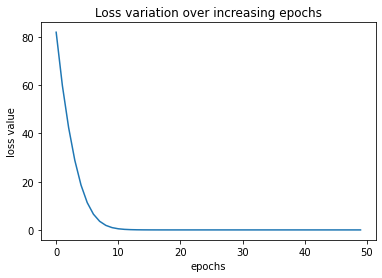

In [48]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.title('Loss variation over increasing epochs')
plt.xlabel('epochs')
plt.ylabel('loss value')

Predicting on a new value

In [49]:
val_x = [[10,11]]
val_x = torch.tensor(val_x).float().to(device)
mynet(val_x)

tensor([[21.1288]], grad_fn=<AddmmBackward>)

Saving a model

In [50]:
torch.save(model.to('cpu').state_dict(), 'mymodel.pth')

Loading a model

In [53]:
# first create an empty model

model = nn.Sequential(
    nn.Linear(2, 8),
    nn.ReLU(),
    nn.Linear(8, 1)
).to(device)

# load the model form disk and unserialize it to crate an orderedDict value
state_dict = torch.load('mymodel.pth')

# load the state_dict onto model
model.load_state_dict(state_dict)
model.to(device)

# make a prediction
model(torch.tensor(val_x).float().to(device))

<ipython-input-53-8bcb8db61074>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model(torch.tensor(val_x).float().to(device))


tensor([[0.7564]], grad_fn=<AddmmBackward>)